In [ ]:
import pandas as pd

# Try reading the file with 'latin-1' encoding
data = pd.read_csv('/content/Superstore.csv', encoding='latin-1')

data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2013-152156,09-11-2013,12-11-2013,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2013-152156,09-11-2013,12-11-2013,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2013-138688,13-06-2013,17-06-2013,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2012-108966,11-10-2012,18-10-2012,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2012-108966,11-10-2012,18-10-2012,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [ ]:
# Convert the 'Order Date' to datetime format
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%d-%m-%Y')

# Select the 'Order Date' and 'Sales' columns
sales_data = data[['Order Date', 'Sales']]

# Calculate the sum of sales for each day
daily_sales = sales_data.groupby('Order Date').sum().reset_index()

# Order the data by date
daily_sales = daily_sales.sort_values(by='Order Date')

# Display the first few rows of the aggregated and sorted sales data
daily_sales.head()


,Order Date,Sales
0,2011-01-04,16.448
1,2011-01-05,288.060
2,2011-01-06,19.536
3,2011-01-07,4407.100
4,2011-01-08,87.158


In [ ]:
daily_sales.shape

(1238, 2)

In [ ]:
# Create a complete date range from the minimum to the maximum date in the dataset
full_date_range = pd.date_range(start=daily_sales['Order Date'].min(),
                                end=daily_sales['Order Date'].max(),
                                freq='D')

# Reindex the daily_sales DataFrame to include all dates in the range
daily_sales = daily_sales.set_index('Order Date').reindex(full_date_range, fill_value=0).rename_axis('Order Date').reset_index()

# Display the first few rows of the updated daily sales data
daily_sales.head()


,Order Date,Sales
0,2011-01-04,16.448
1,2011-01-05,288.060
2,2011-01-06,19.536
3,2011-01-07,4407.100
4,2011-01-08,87.158


In [ ]:
zero_daily_sales=daily_sales[daily_sales['Sales']==0]
zero_daily_sales.shape , daily_sales.shape

((220, 2), (1458, 2))

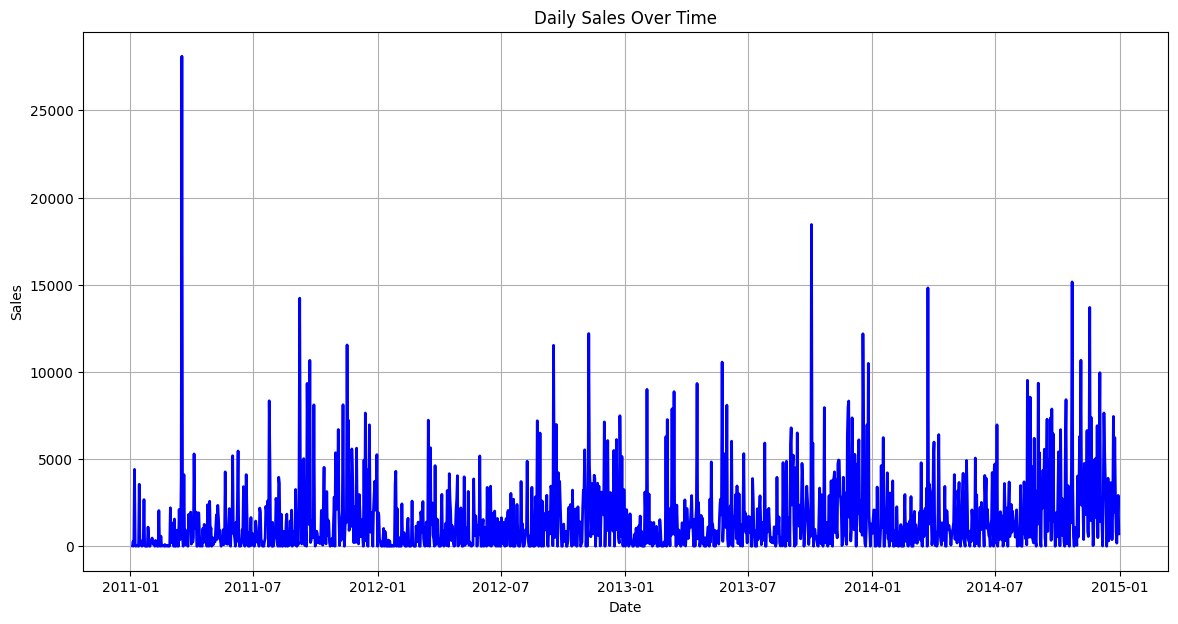

In [ ]:
import matplotlib.pyplot as plt

# Plotting the daily sales to visualize any trends
plt.figure(figsize=(14, 7))
plt.plot(daily_sales['Order Date'], daily_sales['Sales'], color='blue', linewidth=2)
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


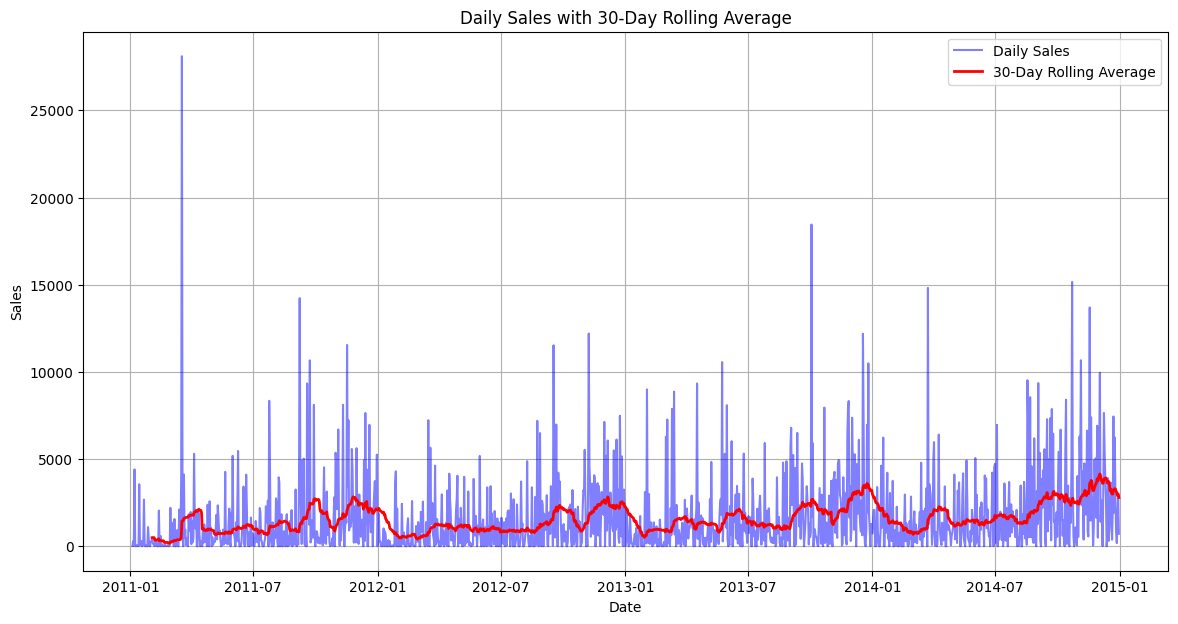

In [ ]:
# Calculate a rolling average with a window of 30 days to smooth out short-term fluctuations
daily_sales['Sales_Rolling_Avg'] = daily_sales['Sales'].rolling(window=30).mean()

# Plot the original sales data along with the rolling average
plt.figure(figsize=(14, 7))
plt.plot(daily_sales['Order Date'], daily_sales['Sales'], label='Daily Sales', color='blue', alpha=0.5)
plt.plot(daily_sales['Order Date'], daily_sales['Sales_Rolling_Avg'], label='30-Day Rolling Average', color='red', linewidth=2)
plt.title('Daily Sales with 30-Day Rolling Average')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
daily_sales.drop(columns=['Sales_Rolling_Avg'], inplace=True)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'daily_sales' is your DataFrame with 'Order Date' and 'Sales' columns

# 1. Feature Engineering: Extract date components and create cyclical features
daily_sales['Year'] = daily_sales['Order Date'].dt.year
daily_sales['DayOfYear'] = daily_sales['Order Date'].dt.dayofyear
daily_sales['Month'] = daily_sales['Order Date'].dt.month

# Cyclical features
daily_sales['DayOfYear_Sin'] = np.sin(2 * np.pi * daily_sales['DayOfYear'] / 365.25)
daily_sales['DayOfYear_Cos'] = np.cos(2 * np.pi * daily_sales['DayOfYear'] / 365.25)
daily_sales['Month_Sin'] = np.sin(2 * np.pi * daily_sales['Month'] / 12)
daily_sales['Month_Cos'] = np.cos(2 * np.pi * daily_sales['Month'] / 12)

# 2. Prepare the Data

# Select the features and convert them to a numpy array
features = ['Sales', 'Year', 'DayOfYear_Sin', 'DayOfYear_Cos', 'Month_Sin', 'Month_Cos']
data = daily_sales[features].values

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Create Training and Validation Sets

# Define the percentage split for the training and validation sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

train, test = scaled_data[:train_size], scaled_data[train_size:]

# 4. Reshape the Data for LSTM

# Reshape into [samples, time steps, features]
X_train = train[:, 1:].reshape((train.shape[0], 1, 5))
X_test = test[:, 1:].reshape((test.shape[0], 1, 5))

y_train = train[:, 0].reshape((train.shape[0], 1))
y_test = test[:, 0].reshape((test.shape[0], 1))

# 5. Build the LSTM Model

model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(1, 5)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 6. Train the Model

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0055 - val_loss: 0.0078
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - val_loss: 0.0082
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - val_loss: 0.0081
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - val_loss: 0.0082
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - val_loss: 0.0075
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 0.0079
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - val_loss: 0.0076
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 0.0079
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - val_loss: 0.0079
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_loss: 0.0078
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063 - val_l

In [ ]:
# 7. Make Predictions

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions and actual values to get them back to the original scale
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], 5))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], 5))), axis=1))[:, 0]

y_train_actual = scaler.inverse_transform(np.concatenate((y_train, np.zeros((y_train.shape[0], 5))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test, np.zeros((y_test.shape[0], 5))), axis=1))[:, 0]

# 8. Evaluate the Model

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))

# Calculate R²
train_r2 = r2_score(y_train_actual, train_predict)
test_r2 = r2_score(y_test_actual, test_predict)

print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Training R²: {train_r2}')
print(f'Test R²: {test_r2}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Training RMSE: 2055.9721318265206
Test RMSE: 2476.2414414708546
Training R²: 0.05250673658028193
Test R²: 0.0344734687247249


In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
# 2. Prepare the Data

# Select the features and convert them to a numpy array
features = ['Sales', 'Year', 'DayOfYear_Sin', 'DayOfYear_Cos', 'Month_Sin', 'Month_Cos']
data = daily_sales[features].values

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Create Training and Validation Sets

# Define the percentage split for the training and validation sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

train, test = scaled_data[:train_size], scaled_data[train_size:]

# 4. Reshape the Data for LSTM

# Reshape into [samples, time steps, features]
X_train = train[:, 1:].reshape((train.shape[0], 1, 5))
X_test = test[:, 1:].reshape((test.shape[0], 1, 5))

y_train = train[:, 0].reshape((train.shape[0], 1))
y_test = test[:, 0].reshape((test.shape[0], 1))

# 5. Build the Complex LSTM Model

model = Sequential()

# Bidirectional LSTM layer with 100 units
model.add(Bidirectional(LSTM(units=100, return_sequences=True), input_shape=(1, 5)))

# Stacked LSTM layer with 50 units
model.add(Bidirectional(LSTM(units=50, return_sequences=False)))

# Add Batch Normalization
model.add(BatchNormalization())

# Add a Dropout layer for regularization
model.add(Dropout(0.3))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 6. Train the Model

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.0234 - val_loss: 0.0084
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - val_loss: 0.0089
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - val_loss: 0.0089
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0059 - val_loss: 0.0091
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058 - val_loss: 0.0091
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0062 - val_loss: 0.0090
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - val_loss: 0.0090
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0074 - val_loss: 0.0089
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0051 - val_loss: 0.0085
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - val_loss: 0.0089
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0069 - val_loss: 0.0093
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0061 -

In [ ]:
# 7. Make Predictions

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions and actual values to get them back to the original scale
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], 5))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], 5))), axis=1))[:, 0]

y_train_actual = scaler.inverse_transform(np.concatenate((y_train, np.zeros((y_train.shape[0], 5))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test, np.zeros((y_test.shape[0], 5))), axis=1))[:, 0]

# 8. Evaluate the Model

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))

# Calculate R²
train_r2 = r2_score(y_train_actual, train_predict)
test_r2 = r2_score(y_test_actual, test_predict)

print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Training R²: {train_r2}')
print(f'Test R²: {test_r2}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training RMSE: 2063.015823166309
Test RMSE: 2521.3563628391917
Training R²: 0.04600345554500729
Test R²: -0.001029097313646421


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Create lag features (e.g., sales from previous days)
for lag in range(1, 8):  # Lag features for the past 7 days
    daily_sales[f'Sales_Lag_{lag}'] = daily_sales['Sales'].shift(lag)

# Drop rows with NaN values (because of the lag)
daily_sales.dropna(inplace=True)

# 2. Prepare the Data

# Select the features and target
features = ['Year', 'DayOfYear_Sin', 'DayOfYear_Cos', 'Month_Sin', 'Month_Cos'] + \
           [f'Sales_Lag_{lag}' for lag in range(1, 8)]
X = daily_sales[features].values
y = daily_sales['Sales'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 3. Train the XGBoost Model

# Pass early_stopping_rounds when creating the XGBRegressor object
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=1000,
                              learning_rate=0.01,
                              early_stopping_rounds=50)  # Add early stopping here

xgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=True)  # No need for early_stopping_rounds in fit

[0]	validation_0-rmse:2115.35915	validation_1-rmse:2666.55210
[1]	validation_0-rmse:2109.08960	validation_1-rmse:2663.15081
[2]	validation_0-rmse:2102.95078	validation_1-rmse:2660.04270
[3]	validation_0-rmse:2096.85710	validation_1-rmse:2656.87345
[4]	validation_0-rmse:2090.84563	validation_1-rmse:2653.78657
[5]	validation_0-rmse:2084.96251	validation_1-rmse:2651.02602
[6]	validation_0-rmse:2079.11680	validation_1-rmse:2648.15069
[7]	validation_0-rmse:2073.20503	validation_1-rmse:2645.35789
[8]	validation_0-rmse:2067.37051	validation_1-rmse:2642.68009
[9]	validation_0-rmse:2061.65482	validation_1-rmse:2640.41710
[10]	validation_0-rmse:2055.97541	validation_1-rmse:2637.90572
[11]	validation_0-rmse:2049.98466	validation_1-rmse:2635.52099
[12]	validation_0-rmse:2044.07657	validation_1-rmse:2633.24986
[13]	validation_0-rmse:2037.73865	validation_1-rmse:2631.59840
[14]	validation_0-rmse:2031.97970	validation_1-rmse:2629.65727
[15]	validation_0-rmse:2025.80467	validation_1-rmse:2628.20434
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Training RMSE: 1705.671606319864
Test RMSE: 2553.74113068556
Training R²: 0.3537000190195767
Test R²: -0.013666778080060116


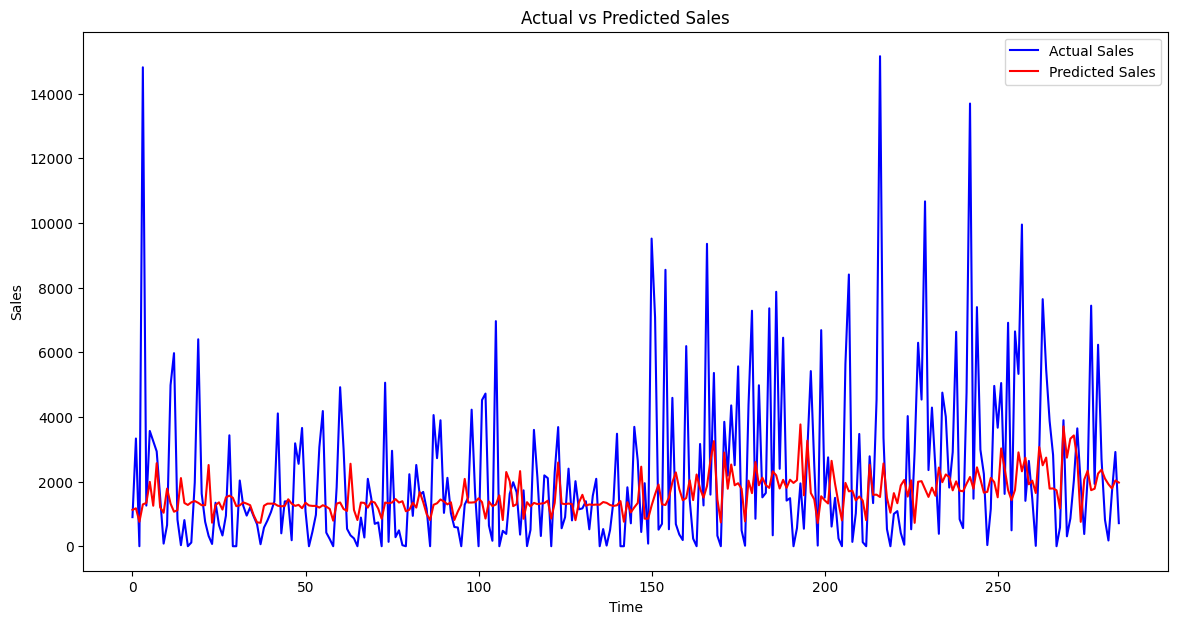

In [ ]:
# Assuming the provided code has been executed, we'll now proceed to evaluate the model and visualize the results.

# 4. Make Predictions
train_predict = xgb_model.predict(X_train)
test_predict = xgb_model.predict(X_test)

# 5. Evaluate the Model

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

# Calculate R²
train_r2 = r2_score(y_train, train_predict)
test_r2 = r2_score(y_test, test_predict)

print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Training R²: {train_r2}')
print(f'Test R²: {test_r2}')

# 6. Plot the Results

plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual Sales', color='blue')
plt.plot(test_predict, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. Feature Engineering and Scaling

# Assuming 'daily_sales' is your DataFrame with 'Sales' and other engineered features

# Create lag features (e.g., sales from previous days)
for lag in range(1, 8):  # Lag features for the past 7 days
    daily_sales[f'Sales_Lag_{lag}'] = daily_sales['Sales'].shift(lag)

# Drop rows with NaN values (because of the lag)
daily_sales.dropna(inplace=True)

# Select the features and target
features = ['Year', 'DayOfYear_Sin', 'DayOfYear_Cos', 'Month_Sin', 'Month_Cos'] + \
           [f'Sales_Lag_{lag}' for lag in range(1, 8)]
X = daily_sales[features].values
y = daily_sales['Sales'].values

# Scale the features and target using MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# 2. Train the XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=1000,
                              learning_rate=0.01,
                              early_stopping_rounds=50)

xgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=True)

[0]	validation_0-rmse:0.07538	validation_1-rmse:0.09495
[1]	validation_0-rmse:0.07516	validation_1-rmse:0.09484
[2]	validation_0-rmse:0.07494	validation_1-rmse:0.09472
[3]	validation_0-rmse:0.07471	validation_1-rmse:0.09462
[4]	validation_0-rmse:0.07450	validation_1-rmse:0.09451
[5]	validation_0-rmse:0.07428	validation_1-rmse:0.09441
[6]	validation_0-rmse:0.07406	validation_1-rmse:0.09431
[7]	validation_0-rmse:0.07386	validation_1-rmse:0.09420
[8]	validation_0-rmse:0.07364	validation_1-rmse:0.09411
[9]	validation_0-rmse:0.07343	validation_1-rmse:0.09401
[10]	validation_0-rmse:0.07321	validation_1-rmse:0.09392
[11]	validation_0-rmse:0.07299	validation_1-rmse:0.09384
[12]	validation_0-rmse:0.07278	validation_1-rmse:0.09375
[13]	validation_0-rmse:0.07257	validation_1-rmse:0.09367
[14]	validation_0-rmse:0.07237	validation_1-rmse:0.09359
[15]	validation_0-rmse:0.07216	validation_1-rmse:0.09352
[16]	validation_0-rmse:0.07196	validation_1-rmse:0.09344
[17]	validation_0-rmse:0.07176	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Training RMSE: 1514.3493223007247
Test RMSE: 2548.5798357441636
Training R²: 0.49222442408484346
Test R²: -0.007065249842823418


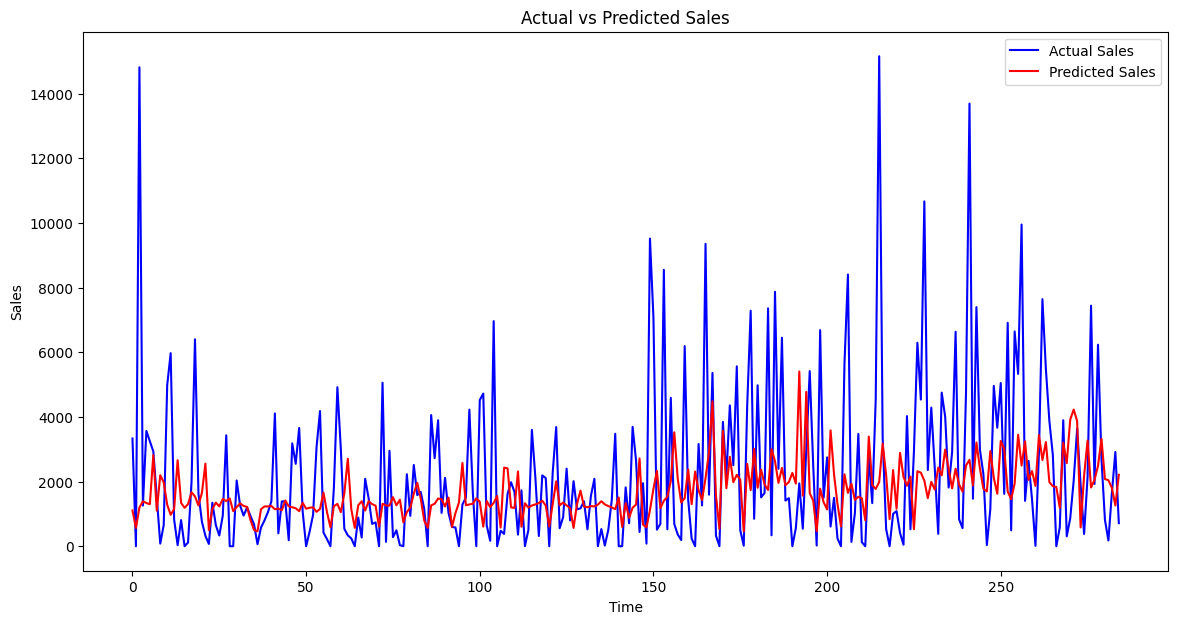

In [ ]:
# 3. Make Predictions
train_predict = xgb_model.predict(X_train)
test_predict = xgb_model.predict(X_test)

# Inverse scaling of predictions and actual values
train_predict = scaler_y.inverse_transform(train_predict.reshape(-1, 1)).flatten()
test_predict = scaler_y.inverse_transform(test_predict.reshape(-1, 1)).flatten()

y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 4. Evaluate the Model

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))

# Calculate R²
train_r2 = r2_score(y_train_actual, train_predict)
test_r2 = r2_score(y_test_actual, test_predict)

print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Training R²: {train_r2}')
print(f'Test R²: {test_r2}')

# 5. Plot the Results

plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual Sales', color='blue')
plt.plot(test_predict, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

Fitting 3 folds for each of 2592 candidates, totalling 7776 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500, 'reg_alpha': 1, 'reg_lambda': 10, 'subsample': 1.0}
Training RMSE: 1883.8150249002622
Test RMSE: 2462.3643542364125
Training R²: 0.2170978297066638
Test R²: 0.06263673945077264


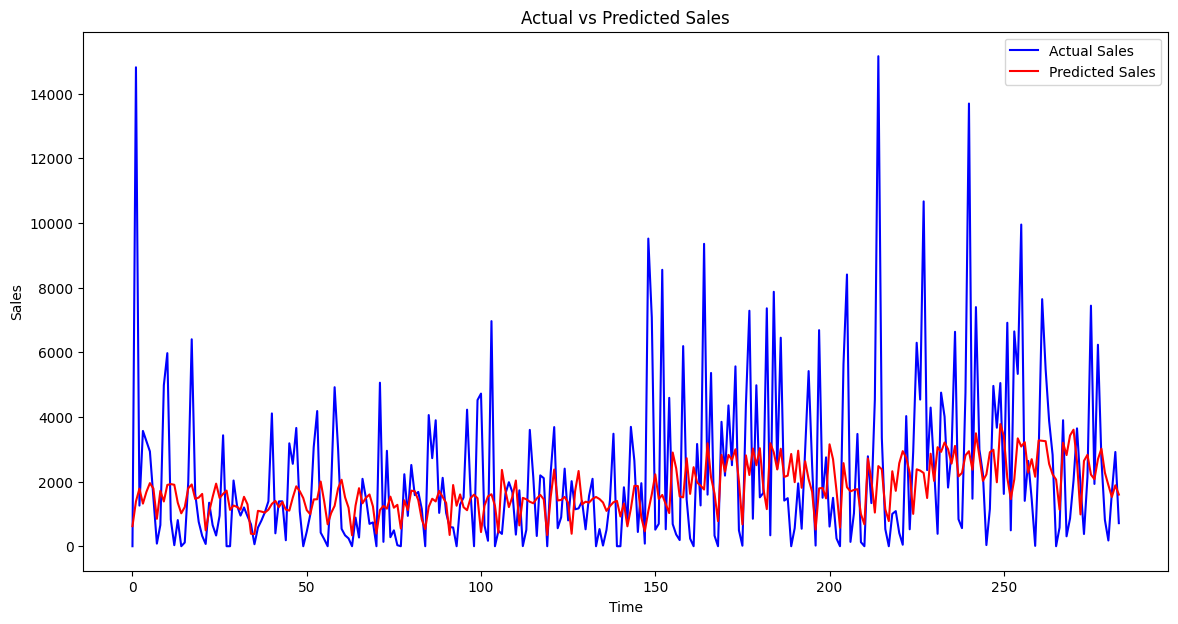

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Assuming 'daily_sales' is your DataFrame with 'Sales' and other engineered features

# 1. Feature Engineering and Scaling

# Create lag features (e.g., sales from previous days)
for lag in range(1, 8):  # Lag features for the past 7 days
    daily_sales[f'Sales_Lag_{lag}'] = daily_sales['Sales'].shift(lag)

# Drop rows with NaN values (because of the lag)
daily_sales.dropna(inplace=True)

# Select the features and target
features = ['Year', 'DayOfYear_Sin', 'DayOfYear_Cos', 'Month_Sin', 'Month_Cos'] + \
           [f'Sales_Lag_{lag}' for lag in range(1, 8)]
X = daily_sales[features].values
y = daily_sales['Sales'].values

# Scale the features and target using MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# 2. Hyperparameter Tuning with GridSearchCV

param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_lambda': [1, 10],
    'reg_alpha': [0, 1]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           cv=3, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the XGBoost Model with the Best Parameters
xgb_best = xgb.XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)

# 3. Make Predictions
train_predict = xgb_best.predict(X_train)
test_predict = xgb_best.predict(X_test)

# Inverse scaling of predictions and actual values
train_predict = scaler_y.inverse_transform(train_predict.reshape(-1, 1)).flatten()
test_predict = scaler_y.inverse_transform(test_predict.reshape(-1, 1)).flatten()

y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 4. Evaluate the Model

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))

# Calculate R²
train_r2 = r2_score(y_train_actual, train_predict)
test_r2 = r2_score(y_test_actual, test_predict)

print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Training R²: {train_r2}')
print(f'Test R²: {test_r2}')

# 5. Plot the Results

plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual Sales', color='blue')
plt.plot(test_predict, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()


----------------------

In [ ]:
import pandas as pd

# Attempt to load the dataset using a different encoding
data = pd.read_csv('/content/Superstore.csv', encoding='ISO-8859-1')

# Display the first few rows of the dataset to understand its structure
data.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2013-152156,09-11-2013,12-11-2013,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2013-152156,09-11-2013,12-11-2013,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2013-138688,13-06-2013,17-06-2013,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2012-108966,11-10-2012,18-10-2012,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2012-108966,11-10-2012,18-10-2012,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [ ]:

# Convert the 'Order Date' to datetime format
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%d-%m-%Y')

# Select relevant columns: Product ID, Category, Sub-Category, Order Date, and Quantity
data_selected = data[['Product ID', 'Category', 'Sub-Category', 'Order Date', 'Quantity']]

# Generate new IDs by label encoding the Product ID
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data_selected['Product_ID'] = label_encoder.fit_transform(data_selected['Product ID'])

# Rename columns to a more suitable format
data_selected.rename(columns={'Category': 'Product_Category',
                              'Sub-Category': 'Product_SubCategory',
                              'Order Date': 'Order_Date',
                              'Quantity': 'Quantity_Sold'}, inplace=True)

# Aggregate data by Product ID, Product Category, Product Sub-Category, and month
data_selected['YearMonth'] = data_selected['Order_Date'].dt.to_period('M')
data_aggregated = data_selected.groupby(['Product_ID', 'Product_Category', 'Product_SubCategory', 'YearMonth'])['Quantity_Sold'].sum().reset_index()

# Display the first few rows of the aggregated data
data_aggregated.head()


<ipython-input-8-39ce5b779e74>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['Product_ID'] = label_encoder.fit_transform(data_selected['Product ID'])
<ipython-input-8-39ce5b779e74>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected.rename(columns={'Category': 'Product_Category',
<ipython-input-8-39ce5b779e74>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,Product_ID,Product_Category,Product_SubCategory,YearMonth,Quantity_Sold
0,0,Furniture,Bookcases,2014-09,9
1,1,Furniture,Bookcases,2011-11,4
2,1,Furniture,Bookcases,2012-09,4
3,1,Furniture,Bookcases,2014-05,2
4,2,Furniture,Bookcases,2011-05,2


In [ ]:
data_selected.shape

(9994, 7)

In [ ]:
# Order the data by YearMonth in ascending order
data_aggregated_sorted = data_aggregated.sort_values(by=['YearMonth'], ascending=True)

# Display the first few rows of the sorted data
data_aggregated_sorted.head()


,Product_ID,Product_Category,Product_SubCategory,YearMonth,Quantity_Sold
8056,1553,Technology,Accessories,2011-01,6
4001,762,Office Supplies,Binders,2011-01,1
7722,1490,Technology,Accessories,2011-01,3
2016,389,Office Supplies,Appliances,2011-01,4
1341,250,Furniture,Furnishings,2011-01,6


In [ ]:
# One-hot encode the Product_Category column
data_one_hot_encoded = pd.get_dummies(data_aggregated_sorted, columns=['Product_Category'])

In [ ]:
# Convert the one-hot encoded columns to 0 and 1 explicitly
one_hot_columns = [col for col in data_one_hot_encoded.columns if 'Product_Category_' in col]
data_one_hot_encoded[one_hot_columns] = data_one_hot_encoded[one_hot_columns].astype(int)

In [ ]:
# Label encode the Product_SubCategory column
data_one_hot_encoded['Product_SubCategory_Encoded'] = label_encoder.fit_transform(data_one_hot_encoded['Product_SubCategory'])

# Drop the original Product_SubCategory column as we now have the encoded version
data_final = data_one_hot_encoded.drop(columns=['Product_SubCategory'])

# Display the first few rows of the final preprocessed dataset
data_final.head()


,Product_ID,YearMonth,Quantity_Sold,Product_Category_Furniture,Product_Category_Office Supplies,Product_Category_Technology,Product_SubCategory_Encoded
8056,1553,2011-01,6,0,0,1,0
4001,762,2011-01,1,0,1,0,3
7722,1490,2011-01,3,0,0,1,0
2016,389,2011-01,4,0,1,0,1
1341,250,2011-01,6,1,0,0,9


In [ ]:
# Create lag features for Quantity_Sold
# We'll create lag features for the past 3 months
data_final['Lag_1'] = data_final.groupby('Product_ID')['Quantity_Sold'].shift(1)
data_final['Lag_2'] = data_final.groupby('Product_ID')['Quantity_Sold'].shift(2)
data_final['Lag_3'] = data_final.groupby('Product_ID')['Quantity_Sold'].shift(3)

# Create moving average features for Quantity_Sold
data_final['MA_3'] = data_final.groupby('Product_ID')['Quantity_Sold'].shift(1).rolling(window=3).mean()
data_final['MA_6'] = data_final.groupby('Product_ID')['Quantity_Sold'].shift(1).rolling(window=6).mean()

# Drop any rows with NaN values resulting from the lag and moving average calculations
data_final = data_final.dropna()

# Display the first few rows of the dataset after feature engineering
data_final.head()


,Product_ID,YearMonth,Quantity_Sold,Product_Category_Furniture,Product_Category_Office Supplies,Product_Category_Technology,Product_SubCategory_Encoded,Lag_1,Lag_2,Lag_3,MA_3,MA_6
6714,1305,2011-12,1,0,1,0,14,2.0,5.0,2.0,2.666667,3.666667
1696,323,2012-03,2,1,0,0,16,14.0,1.0,3.0,6.000000,4.500000
8525,1692,2012-03,2,0,0,1,13,2.0,1.0,2.0,3.000000,4.500000
325,65,2012-04,5,1,0,0,5,7.0,6.0,3.0,7.000000,4.833333
5684,1086,2012-04,2,0,1,0,12,3.0,2.0,3.0,3.000000,3.333333


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the features and target
features = ['Lag_1', 'Lag_2', 'Lag_3', 'MA_3', 'MA_6'] + one_hot_columns + ['Product_SubCategory_Encoded']
X = data_final[features].values
y = data_final['Quantity_Sold'].values

# Split the data into training (60%), validation (20%), and testing (20%) sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=False)

# Train the XGBoost Model with validation
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
eval_set = [(X_val, y_val)]
xgb_model.fit(X_train, y_train, eval_set=eval_set)

[0]	validation_0-rmse:2.57800
[1]	validation_0-rmse:2.57945
[2]	validation_0-rmse:2.58091
[3]	validation_0-rmse:2.58067
[4]	validation_0-rmse:2.58081
[5]	validation_0-rmse:2.58416
[6]	validation_0-rmse:2.58393
[7]	validation_0-rmse:2.58552
[8]	validation_0-rmse:2.58510
[9]	validation_0-rmse:2.58468
[10]	validation_0-rmse:2.58433
[11]	validation_0-rmse:2.58491
[12]	validation_0-rmse:2.58421
[13]	validation_0-rmse:2.58574
[14]	validation_0-rmse:2.58621
[15]	validation_0-rmse:2.58668
[16]	validation_0-rmse:2.58765
[17]	validation_0-rmse:2.58876
[18]	validation_0-rmse:2.58900
[19]	validation_0-rmse:2.58948
[20]	validation_0-rmse:2.59126
[21]	validation_0-rmse:2.59098
[22]	validation_0-rmse:2.59325
[23]	validation_0-rmse:2.59563
[24]	validation_0-rmse:2.59489
[25]	validation_0-rmse:2.59556
[26]	validation_0-rmse:2.59657
[27]	validation_0-rmse:2.59636
[28]	validation_0-rmse:2.59763
[29]	validation_0-rmse:2.60002
[30]	validation_0-rmse:2.60170
[31]	validation_0-rmse:2.60204
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Make predictions on the train, validation, and test sets
train_predict = xgb_model.predict(X_train)
val_predict = xgb_model.predict(X_val)
test_predict = xgb_model.predict(X_test)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
val_rmse = np.sqrt(mean_squared_error(y_val, val_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

train_r2 = r2_score(y_train, train_predict)
val_r2 = r2_score(y_val, val_predict)
test_r2 = r2_score(y_test, test_predict)

print(f'Training RMSE: {train_rmse}')
print(f'Validation RMSE: {val_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Training R²: {train_r2}')
print(f'Validation R²: {val_r2}')
print(f'Test R²: {test_r2}')

Training RMSE: 1.8415477340103936
Validation RMSE: 2.686655181738712
Test RMSE: 3.1462569707968004
Training R²: 0.47468054138032323
Validation R²: -0.08063595251155364
Test R²: -0.1089416900849054


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the features and target
features = ['Lag_1', 'Lag_2', 'Lag_3', 'MA_3', 'MA_6'] + one_hot_columns + ['Product_SubCategory_Encoded']
X = data_final[features].values
y = data_final['Quantity_Sold'].values

# Split the data into training (60%), validation (20%), and testing (20%) sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=False)

# Train the Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the train, validation, and test sets
train_predict = rf_model.predict(X_train)
val_predict = rf_model.predict(X_val)
test_predict = rf_model.predict(X_test)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
val_rmse = np.sqrt(mean_squared_error(y_val, val_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

train_r2 = r2_score(y_train, train_predict)
val_r2 = r2_score(y_val, val_predict)
test_r2 = r2_score(y_test, test_predict)

print(f'Training RMSE: {train_rmse}')
print(f'Validation RMSE: {val_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Training R²: {train_r2}')
print(f'Validation R²: {val_r2}')
print(f'Test R²: {test_r2}')


Training RMSE: 1.9768598244053566
Validation RMSE: 2.6041107163114092
Test RMSE: 3.0453980580349906
Training R²: 0.3946461933615285
Validation R²: -0.015253372173475999
Test R²: -0.03898304931365448


In [ ]:
pip install prophet


In [ ]:
from prophet import Prophet
import pandas as pd

# Prepare the data for Prophet
# We'll create a dictionary to store Prophet models and their forecasts for each product
products_forecasts = {}

# Loop through each Product_ID
for product_id in data_final['Product_ID'].unique():
    # Filter data for the current product
    product_data = data_final[data_final['Product_ID'] == product_id]

    # Prepare the data for Prophet
    product_df = pd.DataFrame({
        'ds': product_data['YearMonth'].dt.to_timestamp(),  # Convert YearMonth to timestamp
        'y': product_data['Quantity_Sold']
    })

    # Filter out products with less than 2 non-NaN rows
    if product_df['y'].notna().sum() < 2:
        continue  # Skip this product

    # Initialize and train the Prophet model
    model = Prophet()
    model.fit(product_df)

    # Create a DataFrame to hold future dates for forecasting
    future = model.make_future_dataframe(periods=12, freq='M')  # Forecast for the next 12 months

    # Generate the forecast
    forecast = model.predict(future)

    # Store the forecast
    products_forecasts[product_id] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Display the forecast for the first product as an example
list(products_forecasts.items())[0]


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoi3epcsl/vpz77pfl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoi3epcsl/fbh6k0zd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76738', 'data', 'file=/tmp/tmpoi3epcsl/vpz77pfl.json', 'init=/tmp/tmpoi3epcsl/fbh6k0zd.json', 'output', 'file=/tmp/tmpoi3epcsl/prophet_modelp6xkmebh/prophet_model-20240823211849.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:18:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:18:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done 

(1305,
            ds       yhat  yhat_lower  yhat_upper
 0  2011-12-01   0.999985    0.999985    0.999985
 1  2014-12-01   1.999986    1.999986    1.999986
 2  2014-12-31  -2.288631   -2.288631   -2.288631
 3  2015-01-31  18.415990   18.415990   18.415990
 4  2015-02-28 -18.776573  -18.776573  -18.776573
 5  2015-03-31 -22.814170  -22.814170  -22.814170
 6  2015-04-30  -3.879426   -3.879426   -3.879426
 7  2015-05-31   1.475590    1.475590    1.475590
 8  2015-06-30 -37.076236  -37.076236  -37.076236
 9  2015-07-31 -19.957940  -19.957940  -19.957940
 10 2015-08-31  -7.229949   -7.229949   -7.229949
 11 2015-09-30  17.504513   17.504513   17.504513
 12 2015-10-31  15.225652   15.225652   15.225652
 13 2015-11-30 -10.255742  -10.255742  -10.255742)

In [ ]:
import pandas as pd

# Combine all forecasts into a single DataFrame
all_forecasts = []

for product_id, forecast in products_forecasts.items():
    forecast['Product_ID'] = product_id  # Add the product ID to the forecast
    all_forecasts.append(forecast)

# Concatenate all forecasts into a single DataFrame
forecast_df = pd.concat(all_forecasts, ignore_index=True)

# Save to CSV
forecast_df.to_csv('forecasted_sales_by_product.csv', index=False)

print("Forecasted data saved successfully.")


Forecasted data saved successfully.


In [ ]:
forecast_df.head()

,ds,yhat,yhat_lower,yhat_upper,Product_ID
0,2011-12-01,0.999985,0.999985,0.999985,1305
1,2014-12-01,1.999986,1.999986,1.999986,1305
2,2014-12-31,-2.288631,-2.288631,-2.288631,1305
3,2015-01-31,18.415990,18.415990,18.415990,1305
4,2015-02-28,-18.776573,-18.776573,-18.776573,1305


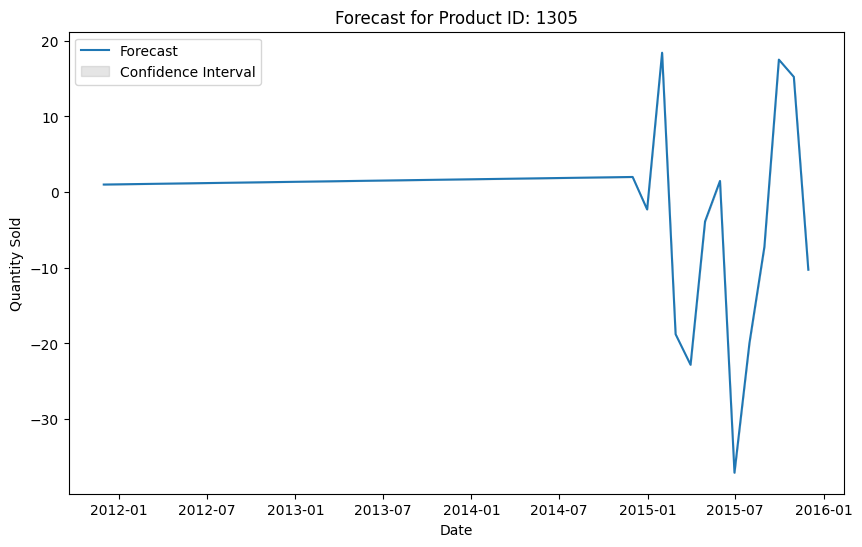

In [ ]:
import matplotlib.pyplot as plt

# Function to plot the forecast for a given product
def plot_forecast(product_id):
    forecast = products_forecasts[product_id]

    plt.figure(figsize=(10, 6))
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Confidence Interval')
    plt.title(f'Forecast for Product ID: {product_id}')
    plt.xlabel('Date')
    plt.ylabel('Quantity Sold')
    plt.legend()
    plt.show()

# Example: Plot the forecast for a specific product
plot_forecast(list(products_forecasts.keys())[0])


In [ ]:
# Assuming the actual sales data is in a DataFrame called df_actual
df_actual = pd.read_csv('forecasted_sales_by_product.csv')  # Replace with your actual file path

# Convert the date column to datetime format if it's not already
df_actual['ds'] = pd.to_datetime(df_actual['ds'])


In [ ]:
# Convert the date column in the forecast DataFrame to datetime format
forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])

# Merge the actual data with the forecast data on date and Product_ID
merged_df = pd.merge(df_actual[['ds', 'Product_ID', 'y']],
                     forecast_df[['ds', 'Product_ID', 'yhat']],
                     on=['ds', 'Product_ID'], how='inner')

# Now you have a merged DataFrame with actual values and predictions


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Define the features and target
features = ['Lag_1', 'Lag_2', 'Lag_3', 'MA_3', 'MA_6'] + one_hot_columns + ['Product_SubCategory_Encoded']
X = data_final[features].values
y = data_final['Quantity_Sold'].values

# Split the data into training (60%), validation (20%), and testing (20%) sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=False)

# Train the Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the train, validation, and test sets
train_predict = lr_model.predict(X_train)
val_predict = lr_model.predict(X_val)
test_predict = lr_model.predict(X_test)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
val_rmse = np.sqrt(mean_squared_error(y_val, val_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

train_r2 = r2_score(y_train, train_predict)
val_r2 = r2_score(y_val, val_predict)
test_r2 = r2_score(y_test, test_predict)

print(f'Training RMSE: {train_rmse}')
print(f'Validation RMSE: {val_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Training R²: {train_r2}')
print(f'Validation R²: {val_r2}')
print(f'Test R²: {test_r2}')
